In [3]:
import sys
!{sys.executable} -m pip install seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

## Datetime grouper

Cilj ovog dijela je iz naseg postojeceg seta dobiti informaciju o broju konekcija, sumama paketa itd u pojedinim ravnomjernim prozorima. Podaci ce se prilagoditi kako bi se lakse plotale relevantne informacije i dobile relacije izmedu odredenih parametara. Ideja je iz tih plotanja i relacija uvidjeti potencijalne anomalije koje nisu (samo) per connection, nego potencijalno vezani kroz sumu konekcija i njihovih velicina u nekom vremenskom (proizvoljno odabranom) prozoru.

In [4]:
df = pd.read_csv('/home/vlado/Desktop/untitled/kyoto/20150101.txt', delimiter='\t', header=None)
df.columns = ["Duration", "Service", "Source bytes", "Destination bytes","Count","Same_srv_rate","Serror_rate","Srv_serror_rate",
               "Dst_host_count","Dst_host_srv_count","Dst_host_same_src_port_rate","Dst_host_serror_rate","Dst_host_srv_serror_rate",
               "Flag","IDS_detection","Malware_detection","Ashula_detection","Label","Source_IP_Address","Source_Port_Number","Destination_IP_Address","Destination_Port_Number","Start_Time","Protocol"]

df['Start_Time'] = pd.to_datetime(df['Start_Time']).dt.time


df = df.sort_values(by=['Start_Time'], ascending=True)   #sortiranje po ts

In [6]:
df = df.set_index(['Start_Time']) #brzi nacin grupiranja po vremenskim prozorima
df.index=pd.to_datetime(df.index, format="%H:%M:%S")

KeyError: "None of ['Start_Time'] are in the columns"

## Plot duration parametra

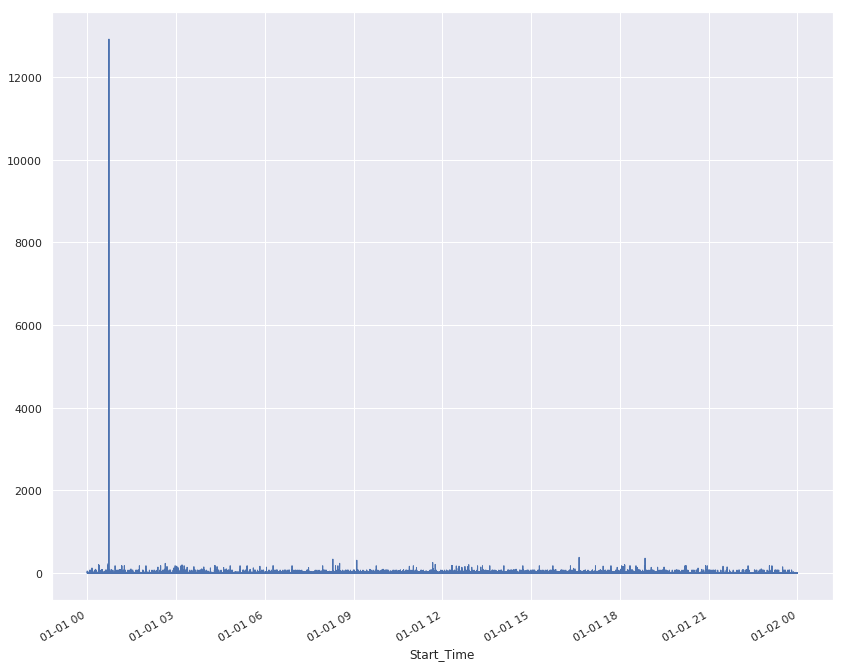

In [13]:
sns.set(rc={'figure.figsize':(14,12)})

df["Duration"].plot(linewidth=1)

## The number of data bytes sent by the destination IP address.

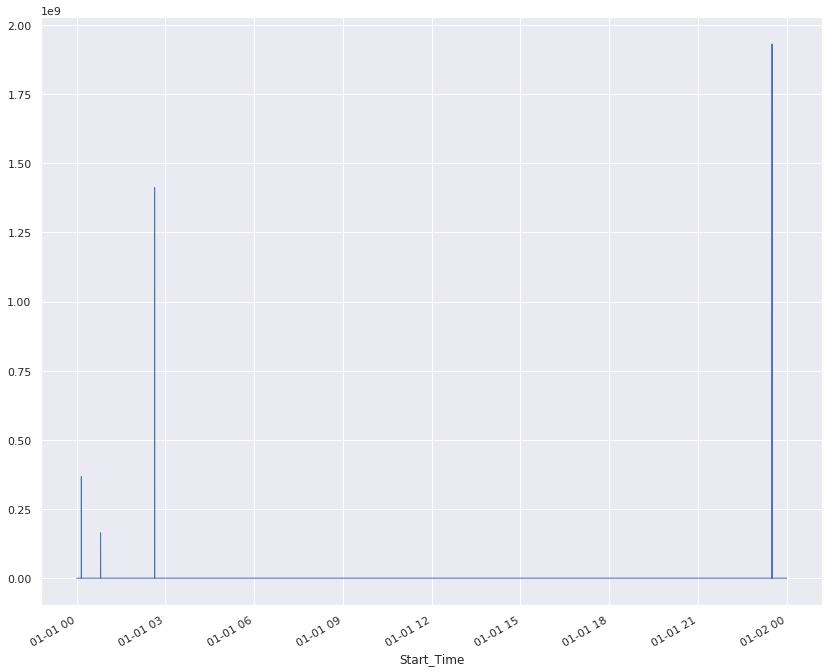

In [15]:
sns.set(rc={'figure.figsize':(14,12)})

df['Destination bytes'].plot(linewidth = 1)

# Count the connections in given time interval

In [18]:
df_count = df.resample('10s').count()         
df_resampled = df.resample('10s').sum()

df_resampled["num_connections"] = df_count["Count"]

In [19]:
#izbacivanje redova koji sadrze sve nule, to su prozori u kojima se nista nije dogodilo

df_resampled = df_resampled.loc[~(df_resampled==0).all(axis=1)]

## Prikaz broja konekcija u intervalu za gledano razdoblje 

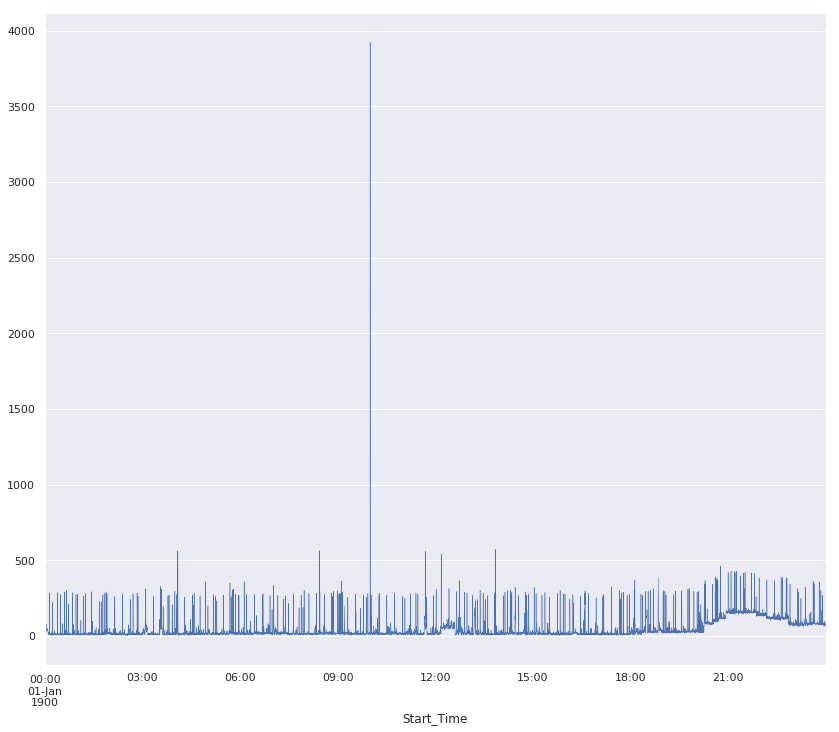

In [20]:
sns.set(rc={'figure.figsize':(14,12)})
df_resampled["num_connections"].plot(linewidth=0.5)


In [21]:
 df_resampled.nlargest(1, 'num_connections')

Duration  Source bytes  Destination bytes  Count  \
Start_Time                                                                
1900-01-01 09:59:50  298.092644           421                 99  32765   

                     Same_srv_rate  Serror_rate  Srv_serror_rate  \
Start_Time                                                         
1900-01-01 09:59:50        3629.96      3483.05          3799.61   

                     Dst_host_count  Dst_host_srv_count  \
Start_Time                                                
1900-01-01 09:59:50             232                 696   

                     Dst_host_same_src_port_rate  Dst_host_serror_rate  \
Start_Time                                                               
1900-01-01 09:59:50                          3.0                  5.39   

                     Dst_host_srv_serror_rate  Label  Source_Port_Number  \
Start_Time                                                                 
1900-01-01 09:59:50                    133.82  -3866            30118961   

                     Destination_Port_Number  num_connections  
Start_Time                                                     
1900-01-01 09:59:50                  4523657             3922

## Broj konekcija u vremenskom intervalu od 10 sec : 

### Po broju DST_HOST_SAME_SRC_PORT_RATE  se moze vidjeti da je broj portova sa kojih je zatrazena konekcija jako razlicit, istih portova ima svega 3 %, sto je indikacija flood ili dos napada



     Cunt - The number of connections whose source IP address and destination IP address are the same to those of the current connection in the past two seconds.  (32765)

     Same_srv_rate - % of connections to the same service in the Count feature.

     Serror_rate - % of connections that have ‘SYN’ errors in Count feature.

     Srv_serror_rate - % of connections that have ‘SYN’ errors in Srv_count (% of connections whose service type is the same to that of the current connections in the past two seconds) feature.

     Dst_host_count - Among the past 100 connections whose destination IP address is the same to that of the current connection, the number of connections whose source IP address is also the same to that of the current connection.

     Dst_host_srv_count - Among the past 100 connections whose destination IP address is the same to that of the current connection, the number of connections whose service type is also the same to that of the current connection.

     Dst_host_same_src_port_rate -  % of connections whose source port is the same to that of the current connection in Dst_host_count feature.
    
     Dst_host_serror_rate	- % of connections that have ‘SYN’ errors in Dst_host_count feature.
    
     Dst_host_srv_serror_rate - % of connections that have ‘SYN’ errors in Dst_host_srv_count feature.
    
     Label - '-1' means know attack is observed, '1' means normal
    
     num_connections - number of connections in observed time interval (10 sec - window)

## Jeli isto računalo izazvalo 4000  konekcija ?

In [23]:
df_ip_adress_check = df

In [26]:
df_with_anomly_and_ip = df_ip_adress_check.loc[(df_ip_adress_check.index >= '1900-01-01 09:59:50') & (df_ip_adress_check.index <= '1900-01-01 10:00:00')]

Text(0, 0.5, 'broj ponavljanja konekcije sa iste ip adrese u oznacenom intervalu')

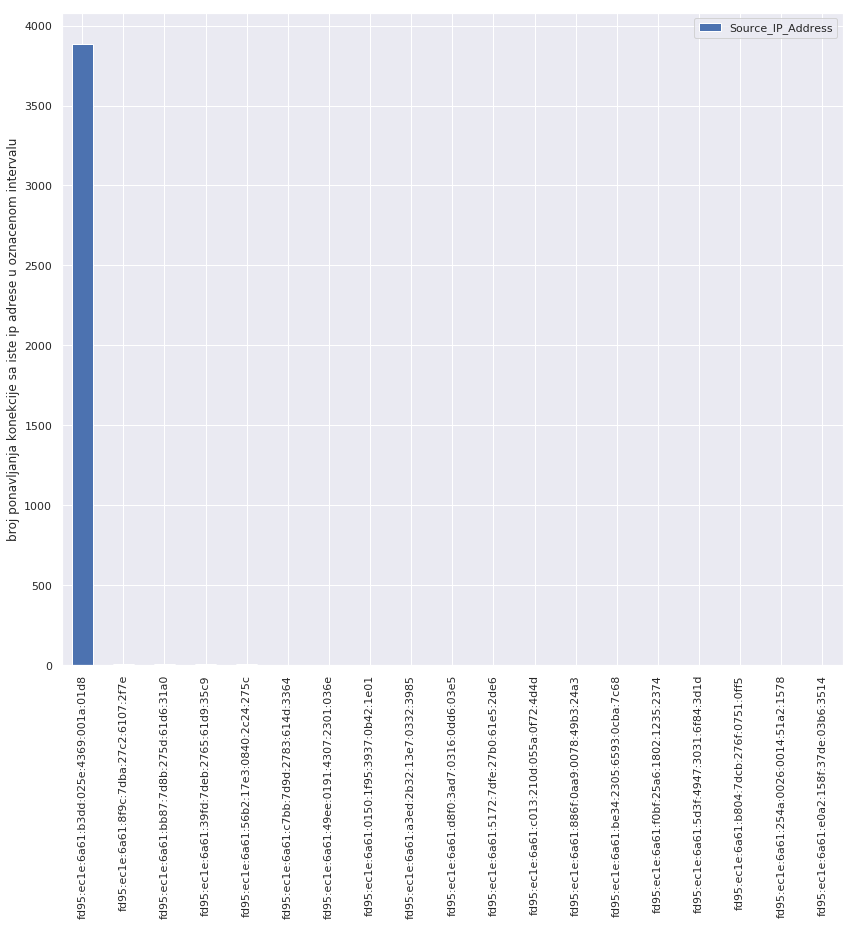

In [29]:
broj_ip_adresa = pd.value_counts(df_with_anomly_and_ip['Source_IP_Address'])
df_broj_adresa = pd.DataFrame(broj_ip_adresa)

ip_plot = df_broj_adresa.plot.bar()
ip_plot.set_ylabel('broj ponavljanja konekcije sa iste ip adrese u oznacenom intervalu')

# Ovo je razlog zasto smo odustali od kyoto dataseta, više od 70 % podataka je anomalija i označeno je greškom

Text(0, 0.5, '-1 - anomalija, -2 - nepoznata anomalija, 1 - normalna veza')

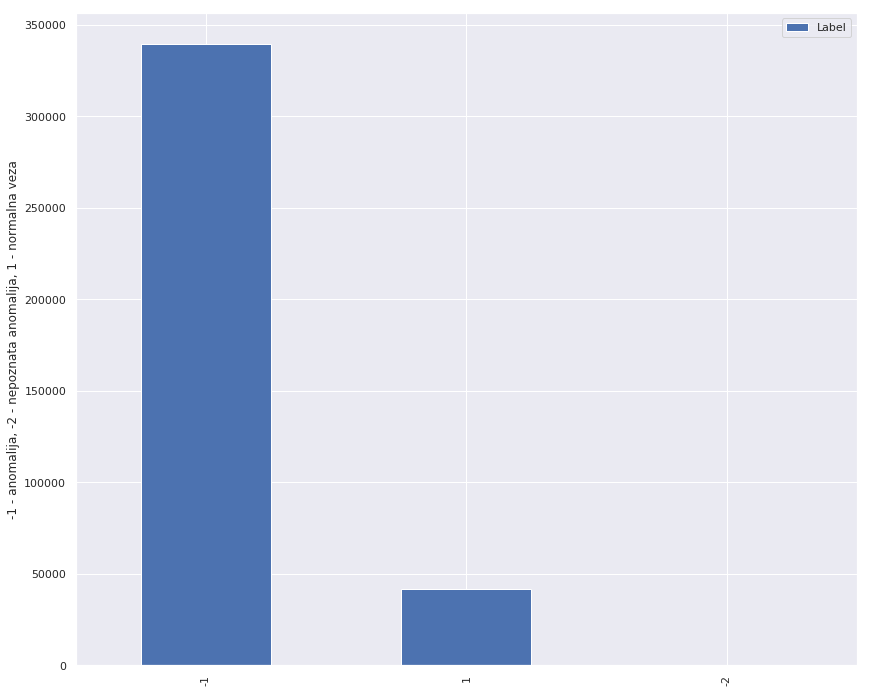

In [35]:
broj_flagova = pd.value_counts(df['Label'])
df_broj_flagova = pd.DataFrame(broj_flagova)
ip_plot = df_broj_flagova.plot.bar()
ip_plot.set_ylabel('-1 - anomalija, -2 - nepoznata anomalija, 1 - normalna veza')

## Prikaz broja servisa u kyoto ds

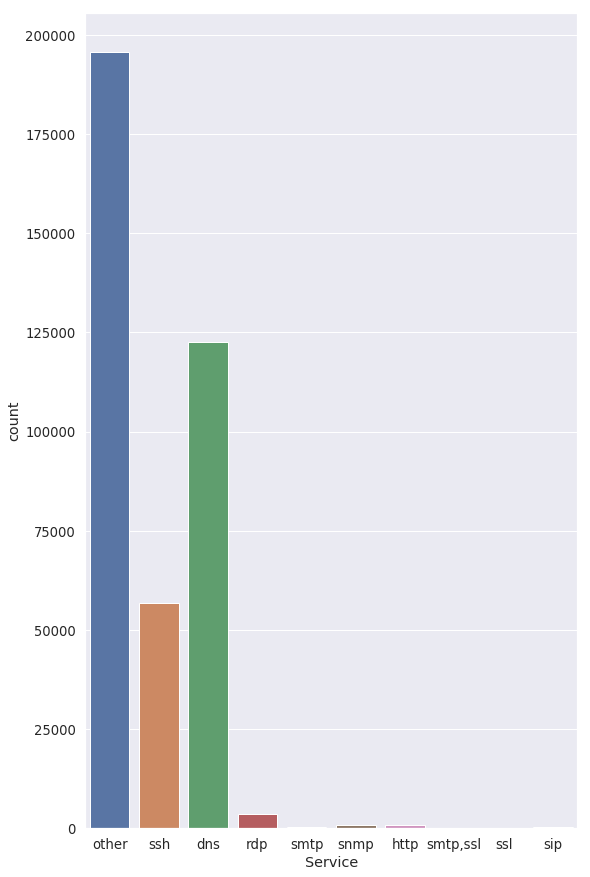

In [125]:
plt.figure(figsize=(30,15))
sns.set(font_scale=1.2)
plt.subplot(131)
sns.countplot(df_2['Service'])

## Indikacije u kyoto ds-u

In [36]:
df_resampled["num_connections"].describe()

count    8640.000000
mean       44.109375
std        73.970639
min         3.000000
25%        12.000000
50%        17.000000
75%        43.000000
max      3922.000000
Name: num_connections, dtype: float64

In [37]:
print(f'Skewness: {df_resampled["num_connections"].skew()}')
print(f'Kurtosis: {df_resampled["num_connections"].kurt()}')
      

Skewness: 18.352764010897722
Kurtosis: 878.6193163477379


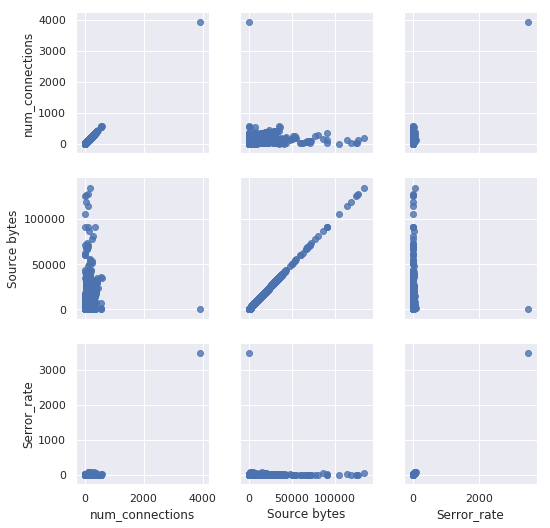

In [64]:
g = sns.PairGrid(df_resampled, vars=['num_connections', 'Source bytes', 'Serror_rate'])
g.map(plt.scatter, alpha=0.8)
# g.add_legend();

# Vrijednosti broja konekcija u odnosu na vremenski interval

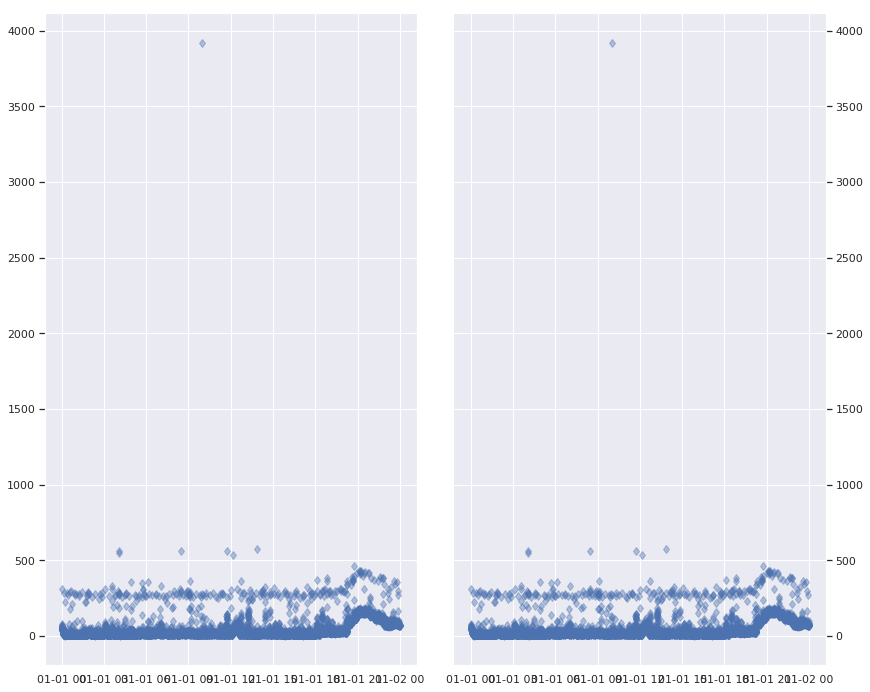

In [63]:
# Plotanje vrijednosti po isjeckanim vremenskih razdobljima kako je u našem setu. 
# Sakrili smo dio u kojem se nista ne dogada(rez)
import matplotlib.pylab as plt
import numpy as np
from datetime import datetime

# If you're not familiar with np.r_, don't worry too much about this. It's just 
# a series with points from 0 to 1 spaced at 0.1, and 9 to 10 with the same spacing.
x = df_resampled.index
y = df_resampled["num_connections"]
#y = df_new_recombined["orig_pkts"]/df_new_recombined["num_connections"]

# x = df['Duration']
# y = df['Destination bytes']

fig,(ax,ax2) = plt.subplots(1, 2, sharey=False)

# plot the same data on both axes
ax.plot(x, y, 'bd' , alpha =0.4)
ax2.plot(x, y, 'bd', alpha =0.4)


# hide the spines between ax and ax2
ax.spines['right'].set_visible(True)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()

ax2.yaxis.tick_right()

# Make the spacing between the two axes a bit smaller
plt.subplots_adjust(wspace=0.10)
plt.show()